# Preprocessing gene and protein data, P1902

This notebook is devoted to preprocessing the gene data from experiment P1902.  We load the metadata for cells, as well as a matrix of counts from scRNA sequencing of cells.  We carry out TPM normalization, and some filtering along the way.  At the end, we take a quick shot at machine learning, to look for a clonal signature in gene expression.

1.  Loading data into a gene expression matrix.
2.  Munging data
3.  Quick shot at maching learning, to make sure data is ok.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
import os # Working with file directories, etc.
from IPython.display import display # Pretty display of data frames.

# Put plots inline rather than in a pop-up.
%matplotlib inline

/opt/anaconda3/envs/Genomics/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1.  Loading the data

Start at section 2, if the raw data has already been processed and pickled.  We load the gene and protein expression data and some metadata about cells and genes.  The data will be loaded and relevant parts will be put into a few dataframes.

## Loading metadata

In [2]:
def get_meta(experiment, filename = '', report=True, invitro = True, bulks = False):
    df = pd.read_csv(filename, sep=',', index_col=1, header=0, low_memory=False)
    df = df.loc[df['Sample_ID'].notnull()] # Only keep cells with sample ID.
    print('Discarding samples without Sample ID.  {} samples remaining.'.format(len(df)))
    df['Project_ID'] = [sid[:5] for sid in df.index] 
    df = df[ df['Project_ID'] == experiment] # Only cells from the experiment.
    print('{} samples found in experiment {}.'.format(len(df), experiment))
    
    df = df.loc[df['Clone_ID'].notnull()] # Only keep cells with Clone ID.
    print('Discarding samples without Clone ID.  {} samples remaining.'.format(len(df)))
    if invitro:
        df = df.loc[df['Condition'] == 'In_Vitro'] 
        print('Discarding samples that are not in-vitro.  {} samples remaining'.format(len(df)))
    df.drop('Sample_ID', axis=1, inplace=True)
    df.index = [cn[:-1] for cn in df.index]
    if bulks:
        df = df[ df['Cell_Number'] > 1] # Include only bulks.
        print('Discarding single cells.  {} bulks remaining'.format(len(df)))
    else:
        df = df[ df['Cell_Number'] == 1] # Get rid of bulks.
        print('Discarding bulks.  {} single cells remaining'.format(len(df)))
    if report:
        if bulks:
            print('{} bulks found in experiment {}'.format(len(df), experiment))
        else:
            print('{} single cells found in experiment {}'.format(len(df), experiment))
        clones = df['Clone_ID'].unique()
        print('{} Clones: {}'.format(len(clones), ', '.join(clones)))
        print('The first five rows of the dataframe are below')
        display(df[:5])
    return df

First we load the data for the single cells (in vitro).

In [3]:
meta_df = get_meta('P1902', filename = 'metadata_marty_NFCORE_Sept2019.csv')
cells = list(meta_df.index)

Discarding samples without Sample ID.  2345 samples remaining.
667 samples found in experiment P1902.
Discarding samples without Clone ID.  624 samples remaining.
Discarding samples that are not in-vitro.  370 samples remaining
Discarding bulks.  361 single cells remaining
361 single cells found in experiment P1902
9 Clones: E4, A7, A8, G6, G8, H2, H9, B4, F3
The first five rows of the dataframe are below


,Condition,Cell_Number,Clone_ID,Day,In_Vivo_Clone_ID,Project_ID
P1902_1289,In_Vitro,1.0,E4,NaN,NaN,P1902
P1902_1290,In_Vitro,1.0,E4,NaN,NaN,P1902
P1902_1291,In_Vitro,1.0,E4,NaN,NaN,P1902
P1902_1292,In_Vitro,1.0,E4,NaN,NaN,P1902
P1902_1293,In_Vitro,1.0,A7,NaN,NaN,P1902


Now the bulks.

In [4]:
meta_bulks = get_meta('P1902', filename = 'metadata_marty_NFCORE_Sept2019.csv', bulks=True)
bulks = list(meta_bulks.index)

Discarding samples without Sample ID.  2345 samples remaining.
667 samples found in experiment P1902.
Discarding samples without Clone ID.  624 samples remaining.
Discarding samples that are not in-vitro.  370 samples remaining
Discarding single cells.  9 bulks remaining
9 bulks found in experiment P1902
4 Clones: E4, A7, H2, B4
The first five rows of the dataframe are below


,Condition,Cell_Number,Clone_ID,Day,In_Vivo_Clone_ID,Project_ID
P1902_1380,In_Vitro,50.0,E4,NaN,NaN,P1902
P1902_1382,In_Vitro,50.0,A7,NaN,NaN,P1902
P1902_1384,In_Vitro,50.0,A7,NaN,NaN,P1902
P1902_1570,In_Vitro,50.0,H2,NaN,NaN,P1902
P1902_1571,In_Vitro,50.0,H2,NaN,NaN,P1902


In [5]:
meta_bulks[['Clone_ID','Cell_Number']]

,Clone_ID,Cell_Number
P1902_1380,E4,50.0
P1902_1382,A7,50.0
P1902_1384,A7,50.0
P1902_1570,H2,50.0
P1902_1571,H2,50.0
P1902_1572,H2,50.0
P1902_1666,B4,50.0
P1902_1667,B4,50.0
P1902_1668,B4,50.0


All of the bulks are 50-cell bulks here.

## Loading gene metadata

Now we load relevant information about the genes.  We've downloaded the [GRCh37 human gene data set](https://grch37.ensembl.org/index.html) from the biomart.

In [6]:
def get_genes(filename):
    df = pd.read_csv(filename, sep='\t',
                     index_col=0, header=0, low_memory=False)
    df.columns = ['Transcript_length', 'Gene_name', 'GC_content','Transcript stable ID', 'TSS']
    print('{} genes found in {}.'.format(len(df), filename))
    return df

In [7]:
gene_raw = get_genes('GRCh37_Biomart.txt')
gene_raw.head()

215404 genes found in GRCh37_Biomart.txt.


,Transcript_length,Gene_name,GC_content,Transcript stable ID,TSS
Gene stable ID,,,,,
ENSG00000261657,2673,SLC25A26,40.0,ENST00000566782,66119285
ENSG00000261657,1096,SLC25A26,40.0,ENST00000562780,66320895
ENSG00000261657,1840,SLC25A26,40.0,ENST00000569579,66320895
ENSG00000261657,3405,SLC25A26,40.0,ENST00000568242,66320895
ENSG00000261657,375,SLC25A26,40.0,ENST00000565530,66339287


There can be many ensembl gene-IDs, for each gene name.  And there can be many transcript-stable IDs for a given ensembl gene-ID.  Since our counts are based on ensembl gene-ID, we use this throughout.  We average transcript length and GC-content for each ensembl gene-ID.

In [8]:
gene_lengths = gene_raw['Transcript_length'].groupby(gene_raw.index).mean()
gene_GCs = gene_raw['GC_content'].groupby(gene_raw.index).mean()
gene_df = pd.DataFrame(gene_lengths, index=gene_lengths.index)
gene_df['GC_content'] = gene_GCs
gene_df['Gene_name'] = gene_raw['Gene_name'].groupby(gene_raw.index).first()
print('{} distinct Ensembl gene IDs found.'.format(len(gene_df)))
gene_df.head()

63677 distinct Ensembl gene IDs found.


,Transcript_length,GC_content,Gene_name
Gene stable ID,,,
ENSG00000000003,1350.333333,40.87,TSPAN6
ENSG00000000005,940.500000,40.80,TNMD
ENSG00000000419,974.714286,39.85,DPM1
ENSG00000000457,3274.400000,40.14,SCYL3
ENSG00000000460,2197.200000,39.22,C1orf112


Our gene metadata now contains all of the Ensembl gene IDs, human-readable gene names, transcript length, and GC content.

## Loading expression counts

Now we load the expression counts.

In [9]:
def get_counts(filename, gdf):
    df = pd.read_csv(filename, sep='\t',
                     index_col=0, header=0, low_memory=False)
    df = df[df.columns[1:]]
    cols = list(df.columns)
    cols = ['_'.join(col.split('_')[3:5]) for col in cols]
    df.columns = cols
    return df

In [10]:
foldername = 'NFCore_Joanna_Mapped_Sept2019/'
counts_df = get_counts(foldername+'P1902_merged_gene_counts.tsv', gene_df)
counts_df_bulks = counts_df[bulks]
counts_df = counts_df[cells]
counts_df.head()

,P1902_1289,P1902_1290,P1902_1291,P1902_1292,P1902_1293,P1902_1294,P1902_1295,P1902_1296,P1902_1297,P1902_1298,...,P1902_1660,P1902_1661,P1902_1662,P1902_1663,P1902_1664,P1902_1665,P1902_1669,P1902_1670,P1902_1671,P1902_1672
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,20,23,0,0,0,0,0,48,0,0,...,17,0,7,0,15,71,0,0,0,0
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We check to make sure that the genes in the count-dataframe are also found in our gene metadata.

In [11]:
genes = [gene for gene in counts_df.index if gene in gene_df.index]
print('{} genes contained in counts and also in gene metadata.'.format(len(genes)))
gene_diff = len(counts_df) - len(genes)
if gene_diff == 0:
    emoticon = ':)'
else:
    emoticon = ':('
print('{} genes have been lost {}'.format(gene_diff, emoticon))

counts_df = counts_df.loc[genes]
gene_df = gene_df.loc[genes]

63677 genes contained in counts and also in gene metadata.
0 genes have been lost :)


## TPM Normalization

Next we carry out TPM normalization on our expression matrix.  We follow the explanation at [the RNA-seq blog](https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/).  More sophisticated methods are possible (e.g., using an "effective transcript length") -- but it should not make too much of a difference for our goals.  The TPM normalization may take 20 seconds or so.

In [12]:
def TPM_norm(cdf, gf, filtergenes = True):
    df = cdf.copy()
    # Step 1:  divide each entry by the transcript length of the gene, in kilobases.
    rdf = 1 / gf['Transcript_length']
    df = df.apply(lambda col : col*1000*rdf) # Multiply by 1000 to convert transcript length to kilobases.
    # Transpose for what follows.
    df = df.transpose()
    # Filter out genes that are never expressed.  Makes stuff faster.
    if filtergenes:
        tot = df.sum(axis=0)
        good_genes = [gene for gene in df.columns if tot[gene] > 0.0]
        print('{} genes filtered out, because they are never expressed.  {} genes remain.'.format(
            len(df.columns) - len(good_genes), len(good_genes)))
        df = df[good_genes]
    # Step 2:  divide each entry by cell-total, then multiply by 1,000,000.
    rdf = 1/df.sum(axis=1)
    df = df.apply(lambda col : col*rdf)
    df = df * 1000000
    # Double-check TPM normalization has succeeded.
    print('The TPM normalization has failed for {} samples.'.format(((df.sum(axis=1) - 1000000) > 0.1).sum()))
    # Return new dataframe.
    return df

In [13]:
EM_raw = TPM_norm(counts_df, gene_df)
EM_raw.head()

39420 genes filtered out, because they are never expressed.  24257 genes remain.
The TPM normalization has failed for 0 samples.


Geneid,ENSG00000227232,ENSG00000233750,ENSG00000237683,ENSG00000239906,ENSG00000241860,ENSG00000222623,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,...,ENSG00000215580,ENSG00000131002,ENSG00000260197,ENSG00000012817,ENSG00000229236,ENSG00000198692,ENSG00000157828,ENSG00000215560,ENSG00000237917,ENSG00000235857
P1902_1289,17.409127,0.0,0.000000,0.0,3.904729,0.0,0.0,15.612185,2.640817,1.991584,...,0.0,0.0,0.0,0.000000,0.0,15.025001,0.0,0.0,0.0,0.0
P1902_1290,17.809043,0.0,0.000000,0.0,0.000000,0.0,0.0,49.764156,0.783038,3.543189,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
P1902_1291,0.000000,0.0,3.250691,0.0,0.000000,0.0,0.0,14.499668,7.941861,3.170853,...,0.0,0.0,0.0,0.000000,0.0,115.355768,0.0,0.0,0.0,0.0
P1902_1292,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,6.600071,22.328173,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
P1902_1293,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,17.604718,11.284506,2.836754,...,0.0,0.0,0.0,4.906722,0.0,0.000000,0.0,0.0,0.0,0.0


Now we carry out the TPM normalization in the same steps, but on the bulks instead of the single cells.

In [14]:
EM_bulks_raw = TPM_norm(counts_df_bulks, gene_df)
EM_bulks_raw.head()

47726 genes filtered out, because they are never expressed.  15951 genes remain.
The TPM normalization has failed for 0 samples.


Geneid,ENSG00000227232,ENSG00000237683,ENSG00000241860,ENSG00000237094,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,ENSG00000240409,ENSG00000248527,...,ENSG00000183878,ENSG00000215414,ENSG00000154620,ENSG00000176728,ENSG00000215580,ENSG00000131002,ENSG00000260197,ENSG00000012817,ENSG00000198692,ENSG00000237917
P1902_1380,1.453124,0.365188,0.0,0.000000,0.000000,44.058372,15.954686,6.174468,0.000000,711.582204,...,5.046665,0.883223,0.000000,0.0,0.0,22.585800,0.000000,0.000000,135.684189,0.00000
P1902_1382,0.744221,0.000000,0.0,0.000000,0.000000,17.426642,12.794420,2.837932,5.610057,761.682622,...,1.600028,0.000000,0.000000,0.0,0.0,20.888315,0.290393,3.708841,157.863527,0.00000
P1902_1384,0.695663,3.127496,0.0,0.530139,0.972682,16.636214,28.374825,3.713876,3.496016,1119.518252,...,2.876217,0.000000,0.000000,0.0,0.0,15.137700,0.000000,1.325562,206.802492,0.15483
P1902_1570,1.678141,0.000000,0.0,0.000000,0.000000,25.583749,8.824740,2.303729,2.530021,978.215414,...,5.661627,0.713994,0.000000,0.0,0.0,0.000000,0.000000,0.295167,137.108117,0.00000
P1902_1571,2.450329,0.000000,0.0,0.000000,0.856517,15.564990,13.422290,2.335957,3.078498,1401.760675,...,0.607853,1.737557,7.636297,0.0,0.0,10.238872,0.000000,9.876767,149.208378,0.00000


## Loading protein data
Now we load the protein data.  We give a list of "default" proteins to look for here.

In [15]:
proteins_default = ['CD57', 'FAS', 'PTPRC-CD45RA', 'CD4', 'IL7RA','Dextramer', 
                    'CD3E', 'CD8A', 'CCR7', 'ITGA6-CD49F', 'PDCD1', 'CD27']

In [16]:
def get_proteins(filename, cell_list, proteins = proteins_default):
    df = pd.read_csv(filename, sep=',',
                      index_col=0, header=0, low_memory=False)
    df = df.reindex(cell_list)
    proteins_occurring = [p for p in proteins if p in df.columns]
    df = df[proteins_occurring]
    #df = df.apply(pd.to_numeric, errors='coerce')
    print('Average protein measurement for {} samples and {} proteins.'.format(len(df), len(df.columns)))
    display(df.mean(axis=0))
    return df

In [17]:
protein_df = get_proteins('P1902_protein.csv', cells)
protein_df.head()

Average protein measurement for 361 samples and 12 proteins.


CD57              969.149584
FAS              8226.617729
PTPRC-CD45RA     1587.936288
CD4                82.263158
IL7RA            -710.193906
Dextramer        7256.545706
CD3E             2637.030471
CD8A            16948.761773
CCR7               93.324100
ITGA6-CD49F       -41.060942
PDCD1             674.795014
CD27              -36.819945
dtype: float64

,CD57,FAS,PTPRC-CD45RA,CD4,IL7RA,Dextramer,CD3E,CD8A,CCR7,ITGA6-CD49F,PDCD1,CD27
cell tag,,,,,,,,,,,,
P1902_1289,41.0,2571.0,379.0,-35.0,-2078.0,4308.0,1279.0,32958.0,318.0,-163.0,507.0,-926.0
P1902_1290,5.0,10302.0,461.0,77.0,-662.0,2946.0,3212.0,12922.0,105.0,-128.0,145.0,5.0
P1902_1291,38.0,5480.0,999.0,-53.0,-1761.0,7775.0,3231.0,28156.0,152.0,-207.0,853.0,-528.0
P1902_1292,138.0,6633.0,13.0,-102.0,-59.0,1056.0,1096.0,3917.0,59.0,39.0,74.0,-22.0
P1902_1293,71.0,4569.0,1219.0,196.0,-327.0,20174.0,3702.0,20049.0,41.0,91.0,-381.0,1116.0


In [18]:
protein_bulks = get_proteins('P1902_protein.csv', bulks)
protein_bulks.head()

Average protein measurement for 9 samples and 12 proteins.


CD57               38.750
FAS              7597.375
PTPRC-CD45RA     2860.750
CD4                64.500
IL7RA            -345.375
Dextramer       10266.875
CD3E             2996.500
CD8A            15849.750
CCR7               58.750
ITGA6-CD49F        11.750
PDCD1             304.500
CD27              392.375
dtype: float64

,CD57,FAS,PTPRC-CD45RA,CD4,IL7RA,Dextramer,CD3E,CD8A,CCR7,ITGA6-CD49F,PDCD1,CD27
cell tag,,,,,,,,,,,,
P1902_1380,96.0,10453.0,16.0,61.0,-803.0,2556.0,2276.0,22351.0,199.0,-221.0,522.0,-302.0
P1902_1382,57.0,3087.0,11097.0,53.0,-537.0,13634.0,1899.0,17002.0,48.0,34.0,-236.0,187.0
P1902_1384,-8.0,8618.0,8240.0,280.0,-483.0,9826.0,1753.0,13993.0,48.0,-31.0,246.0,374.0
P1902_1570,21.0,6562.0,830.0,-118.0,-284.0,16784.0,3913.0,16964.0,43.0,160.0,-450.0,1139.0
P1902_1571,49.0,1845.0,168.0,74.0,169.0,16762.0,3783.0,11763.0,-6.0,244.0,-436.0,271.0


## Pickling

We pickle all of our loaded data frames, just in case.

In [19]:
experiment = 'P1902' # Change this to whatever the experiment is!

In [20]:
gene_df.to_pickle(experiment+'_genes.pkl') # Save file as a pickle.
EM_raw.to_pickle(experiment+'_EM_raw.pkl') # Save file as a pickle.
EM_bulks_raw.to_pickle(experiment+'_EM_bulks_raw.pkl') # Save file as a pickle.
meta_df.to_pickle(experiment+'_meta.pkl') # Pickle the metadata too.
meta_bulks.to_pickle(experiment+'_meta_bulks.pkl') # Pickle the metadata too.
protein_df.to_pickle(experiment+'_protein.pkl') # Pickled proteins.  Mmmmm...
protein_bulks.to_pickle(experiment+'_protein_bulks.pkl') # Pickled proteins.  Mmmmm...

# 2.  Munging data

Now we filter and log-scale the gene expression data, for downstream use.

## Reloading data from pickles.

Just in case we need it, we load the data from the pickles.

In [21]:
experiment = 'P1902'

In [22]:
gene_df = pd.read_pickle(experiment+'_genes.pkl') # Load gene metadata.
EM_raw = pd.read_pickle(experiment+'_EM_raw.pkl') # Load expression matrix from a pickle.
EM_bulks_raw = pd.read_pickle(experiment+'_EM_bulks_raw.pkl') # Load bulks expression matrix from a pickle.
meta_df = pd.read_pickle(experiment+'_meta.pkl') # Load metadata from a pickle.
meta_bulks = pd.read_pickle(experiment+'_meta_bulks.pkl') # Load metadata from a pickle.
protein_df = pd.read_pickle(experiment+'_protein.pkl') # Load proteins from a pickle.
protein_bulks = pd.read_pickle(experiment+'_protein_bulks.pkl') # Load proteins from a pickle.

In [23]:
genes = list(gene_df['Gene_name'])  # The names of the genes in the expression matrix for single cells.
cells = list(EM_raw.index) # The names of the cells.
bulks = list(EM_bulks_raw.index) # The names of the bulks.
proteins = list(protein_df.columns) # The names of the proteins.
clones = sorted(list(meta_df.Clone_ID.unique())) # The names of the clones.

### Removing TCRs and rarely-expressed genes

T cells have special genetically rearranged receptors called TCRs.  These are made of segments called TRBV9, TRBJ2-4, TRAV12-2, TRAJ14, etc.  TR genes are clonal by nature, and therefore we exclude these genes from later analysis.  We have downloaded a list of TR genes from [the HGNC database](https://www.genenames.org/data/genegroup/#!/group/370), and put them in a dataframe here.

In [26]:
gene_df['Gene_name']

Gene stable ID
ENSG00000223972       DDX11L1
ENSG00000227232        WASH7P
ENSG00000243485    MIR1302-10
ENSG00000237613       FAM138A
ENSG00000268020        OR4G4P
                      ...    
ENSG00000224240       CYCSP49
ENSG00000227629    SLC25A15P1
ENSG00000237917       PARP4P1
ENSG00000231514       FAM58CP
ENSG00000235857       CTBP2P1
Name: Gene_name, Length: 63677, dtype: object

In [28]:
TR_df = pd.read_csv('TR_genelist.tsv', sep='\t')

TR_df = pd.read_csv('TR_genelist.tsv', sep='\t')
TR_symbols = TR_df['Approved symbol'].unique()
TR_genes = gene_df[gene_df['Gene_name'].isin(TR_symbols)].index # Get ENSG with names matching TR-list.
print('{} TCRs will be excluded:  {}'.format(len(TR_genes), ', '.join(TR_symbols)))

291 TCRs will be excluded:  TRA, TRAV8-1, TRAJ45, TRAJ46, TRAJ47, TRAJ48, TRAJ49, TRAJ50, TRAJ51, TRAJ52, TRAJ53, TRAJ54, TRAV8-2, TRAJ55, TRAJ56, TRAJ57, TRAJ58, TRAJ59, TRAJ60, TRAJ61, TRAC, TRAV8-3, TRAV8-4, TRAV8-5, TRAV8-6, TRAV8-7, TRAV9-1, TRAV9-2, TRAV10, TRAV1-1, TRAV11, TRAV12-1, TRAV12-2, TRAV12-3, TRAV13-1, TRAV13-2, TRAV14DV4, TRAV15, TRAV16, TRAV17, TRAV1-2, TRAV18, TRAV19, TRAV20, TRAV21, TRAV22, TRAV23DV6, TRAV24, TRAV25, TRAV26-1, TRAV26-2, TRAV2, TRAV27, TRAV28, TRAV29DV5, TRAV30, TRAV31, TRAV32, TRAV33, TRAV34, TRAV35, TRAV36DV7, TRAV3, TRAV37, TRAV38-1, TRAV38-2DV8, TRAV39, TRAV40, TRAV41, TRAJ1, TRAJ2, TRAJ3, TRAJ4, TRAV4, TRAJ5, TRAJ6, TRAJ7, TRAJ8, TRAJ9, TRAJ10, TRAJ11, TRAJ12, TRAJ13, TRAJ14, TRAV5, TRAJ15, TRAJ16, TRAJ17, TRAJ18, TRAJ19, TRAJ20, TRAJ21, TRAJ22, TRAJ23, TRAJ24, TRAV6, TRAJ25, TRAJ26, TRAJ27, TRAJ28, TRAJ29, TRAJ30, TRAJ31, TRAJ32, TRAJ33, TRAJ34, TRAV7, TRAJ35, TRAJ36, TRAJ37, TRAJ38, TRAJ39, TRAJ40, TRAJ41, TRAJ42, TRAJ43, TRAJ44, TRBV20OR9-2,

Now we filter our genes.  We consider genes relevant if (1) they are not TR genes, (2) they are found in at least 5% of cells at a level of 10 or higher (TPM-normalized count).

In [29]:
def get_relevant(EM, excluded_genes, prevalence=0.05, threshold = 10):
    '''
    Returns genes that are "relevant" meaning that...  
    1.  We throw out excluded genes.
    2.  The gene occurs in at least 5% of all cells at a level of 10 counts or more.
    '''
    nonzero_count = (EM > threshold).sum(axis=0)
    nonzero_proportion = nonzero_count / len(EM)
    good_genes = EM.columns
    num_genes = len(good_genes)
    print('Starting with {} genes in expression matrix'.format(num_genes))
    good_genes = [gene for gene in good_genes if (gene not in excluded_genes)]
    print('{} TR-genes excluded.'.format(num_genes - len(good_genes)))
    num_genes = len(good_genes)
    good_genes = [gene for gene in good_genes if (nonzero_proportion[gene] > prevalence)]
    print('{} genes excluded due to low prevalence.'.format(num_genes - len(good_genes)))
    print('{} genes remain.'.format(len(good_genes)))
    return good_genes

In [30]:
genes_relevant = get_relevant(EM_raw, TR_genes)

Starting with 24257 genes in expression matrix
131 TR-genes excluded.
16682 genes excluded due to low prevalence.
7444 genes remain.


In [31]:
genes_relevant_bulks = get_relevant(EM_bulks_raw, TR_genes)

Starting with 15951 genes in expression matrix
96 TR-genes excluded.
6768 genes excluded due to low prevalence.
9087 genes remain.


### Removing poor quality libraries and overexpressing cells

Next we remove poor quality libraries -- by removing cells which express too few genes.  We also remove cells that may be dividing, and thus express too many genes.  To visualize this, we produce "violin-plots" giving the number of genes expressed by each cell, sorted by clonality.

In [32]:
def nGene(ge, md, cutoff = 10, plot=True, ylim = True, find_bad = True):
    nG = ge.apply(lambda row: sum(row > cutoff), axis=1) # Number of genes expressed.
    nG.name = 'num_genes'
    clonalities = md.Clone_ID
    clonelist = clonalities.unique()
    nGene_df = pd.concat([nG, clonalities], axis=1)
    if find_bad:
        nG_std = nGene_df.groupby('Clone_ID').apply(np.std)
        nG_means = nGene_df.groupby('Clone_ID').apply(np.mean)
        nG_lowcut = (nG_means - 2*nG_std).num_genes
        nG_highcut = (nG_means + 2*nG_std).num_genes
        cells_good = [c for c in ge.index if 
                      (nGene_df.num_genes[c] >= nG_lowcut[nGene_df.Clone_ID[c]]) and 
                      (nGene_df.num_genes[c] <= nG_highcut[nGene_df.Clone_ID[c]]) 
                     ]
        cells_bad = [c for c in ge.index if c not in cells_good]
    else:
        cells_good = list(ge.index)
        cells_bad = []
    if plot:
        fig,ax = plt.subplots(figsize=(12,8))
        sns.violinplot(x="Clone_ID", y="num_genes", inner='quartiles', data=nGene_df, 
                       ax=ax, order=clonelist)
        sns.swarmplot(x="Clone_ID", y="num_genes", color="white", size=3, data=nGene_df.loc[cells_good], 
                      ax=ax, order=clonelist);
        sns.swarmplot(x="Clone_ID", y="num_genes", color="red", size=6, edgecolor='black', linewidth=1,
                      data=nGene_df.loc[cells_bad], ax=ax, order=clonelist);
        if ylim:
            ax.set_ylim(0,5000)
        plt.savefig("test.svg")
    return nGene_df, cells_good

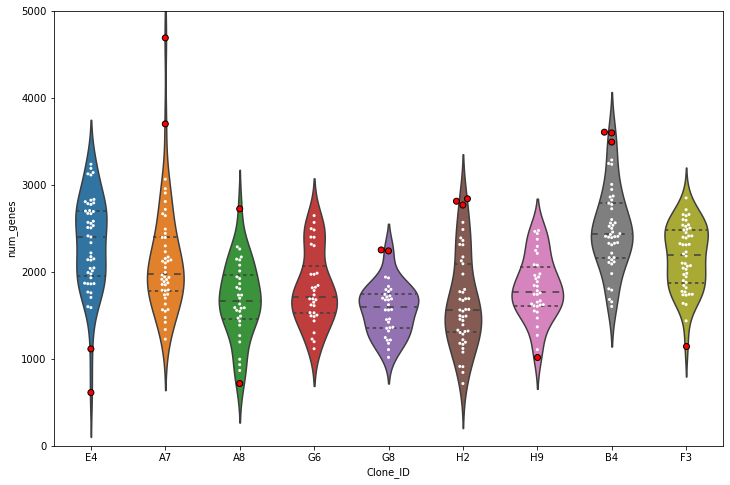

In [33]:
nG, cells_good = nGene(EM_raw, meta_df)

In [34]:
print('{} cells remaining after {} poor libraries removed.'.format(len(cells_good), len(cells) - len(cells_good)))

345 cells remaining after 16 poor libraries removed.


In [35]:
clone_pops = pd.DataFrame(meta_df.loc[cells].Clone_ID.value_counts(), index=meta_df.loc[cells].Clone_ID.unique())
clone_pops.columns = ['Before bad cells removed']
clone_pops['After bad cells removed'] = meta_df.loc[cells_good].Clone_ID.value_counts()
display(clone_pops)

,Before bad cells removed,After bad cells removed
E4,47,45
A7,46,44
A8,32,30
G6,32,32
G8,32,30
H2,45,42
H9,34,33
B4,45,42
F3,48,47


We also look at the violin plots for the bulks, just to check on the numbers of expressed genes for each 50-cell bulk.

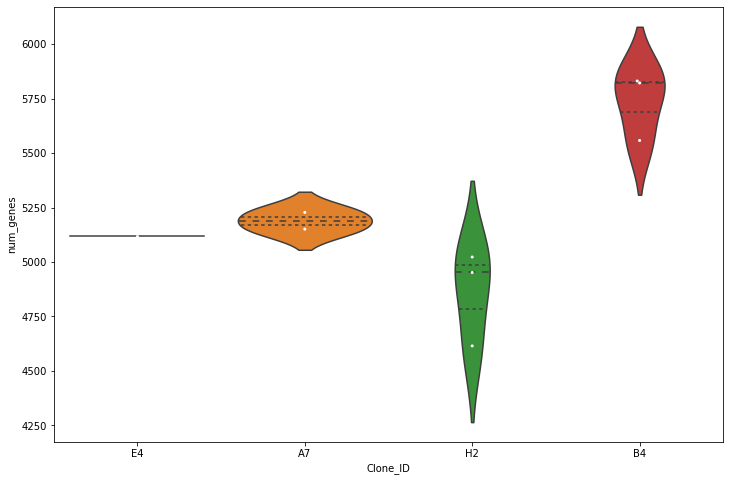

In [36]:
nG_bulks = nGene(EM_bulks_raw, meta_bulks, ylim=False) # Violin-plot for bulks

### Clipping and log-normalization

Now we normalize our gene expression matrix.  We only use the good cells (throwing out bad libraries) and relevant genes (as determined by the single cells).  We cut off all negative gene-expression, and normalize the gene expression on a log-scale.  In the end, a gene-expression value of $x$ will be replaced by $\log_2(1 + max(x,0))$ (logarithm base 2).

In [37]:
EM_raw.head()

Geneid,ENSG00000227232,ENSG00000233750,ENSG00000237683,ENSG00000239906,ENSG00000241860,ENSG00000222623,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,...,ENSG00000215580,ENSG00000131002,ENSG00000260197,ENSG00000012817,ENSG00000229236,ENSG00000198692,ENSG00000157828,ENSG00000215560,ENSG00000237917,ENSG00000235857
P1902_1289,17.409127,0.0,0.000000,0.0,3.904729,0.0,0.0,15.612185,2.640817,1.991584,...,0.0,0.0,0.0,0.000000,0.0,15.025001,0.0,0.0,0.0,0.0
P1902_1290,17.809043,0.0,0.000000,0.0,0.000000,0.0,0.0,49.764156,0.783038,3.543189,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
P1902_1291,0.000000,0.0,3.250691,0.0,0.000000,0.0,0.0,14.499668,7.941861,3.170853,...,0.0,0.0,0.0,0.000000,0.0,115.355768,0.0,0.0,0.0,0.0
P1902_1292,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,6.600071,22.328173,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
P1902_1293,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,17.604718,11.284506,2.836754,...,0.0,0.0,0.0,4.906722,0.0,0.000000,0.0,0.0,0.0,0.0


In [38]:
EM_bulks_raw.head()

Geneid,ENSG00000227232,ENSG00000237683,ENSG00000241860,ENSG00000237094,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,ENSG00000240409,ENSG00000248527,...,ENSG00000183878,ENSG00000215414,ENSG00000154620,ENSG00000176728,ENSG00000215580,ENSG00000131002,ENSG00000260197,ENSG00000012817,ENSG00000198692,ENSG00000237917
P1902_1380,1.453124,0.365188,0.0,0.000000,0.000000,44.058372,15.954686,6.174468,0.000000,711.582204,...,5.046665,0.883223,0.000000,0.0,0.0,22.585800,0.000000,0.000000,135.684189,0.00000
P1902_1382,0.744221,0.000000,0.0,0.000000,0.000000,17.426642,12.794420,2.837932,5.610057,761.682622,...,1.600028,0.000000,0.000000,0.0,0.0,20.888315,0.290393,3.708841,157.863527,0.00000
P1902_1384,0.695663,3.127496,0.0,0.530139,0.972682,16.636214,28.374825,3.713876,3.496016,1119.518252,...,2.876217,0.000000,0.000000,0.0,0.0,15.137700,0.000000,1.325562,206.802492,0.15483
P1902_1570,1.678141,0.000000,0.0,0.000000,0.000000,25.583749,8.824740,2.303729,2.530021,978.215414,...,5.661627,0.713994,0.000000,0.0,0.0,0.000000,0.000000,0.295167,137.108117,0.00000
P1902_1571,2.450329,0.000000,0.0,0.000000,0.856517,15.564990,13.422290,2.335957,3.078498,1401.760675,...,0.607853,1.737557,7.636297,0.0,0.0,10.238872,0.000000,9.876767,149.208378,0.00000


In [46]:
def log2p(x):
    return np.log1p(x) / np.log(2) # For later use.

EM = EM_raw[genes_relevant].copy()  # Only use relevant genes.
EM = EM.loc[cells_good] # Only use good cells.
EM.clip(lower=0, inplace = True) # Clip any negative values to zero.
EM = EM.transform(np.log1p) / np.log(2)  # Apply log2(1+x) transform.

EM_bulks = EM_bulks_raw[genes_relevant_bulks].copy()  # Only use relevant genes.
EM_bulks.clip(lower=0, inplace = True) # Clip any negative values to zero.
EM_bulks = EM_bulks.transform(np.log1p) / np.log(2) # Apply log2(1+x) transform.

In [47]:
print('Expression matrix for single cells of shape {}'.format(EM.shape))
print('Expression matrix for bulks of shape {}'.format(EM_bulks.shape))

Expression matrix for single cells of shape (345, 7444)
Expression matrix for bulks of shape (9, 9087)


## Examination of dropouts and suspicious genes for single cells

Now we examine the zeros (dropouts) and means in this matrix.  For each gene, we look at two quantities:  the *nonzero ratio* is the proportion of cells which express the gene (above the cutoff).  The *mean nonzero* is the mean of the (log-normalized) expression of the gene, restricting to the expressions above the cutoff.

The following function creates a dataframe with the nonzero ratio and mean nonzero value for every gene, using a given cutoff.  By default, the cutoff should be given in "absolute" terms, i.e., before log-normalization.  A cutoff of 10 seems reasonable.

In [51]:
def dropmean(df, cutoff, absolute=True):
    behave_df = df.copy()
    no_cells = len(behave_df)
    max_expression = behave_df.max()
    if absolute:
        co = log2p(cutoff)
    else:
        co = cutoff
    behave_df = behave_df.clip(co,max(max_expression))
    dropout_df = behave_df.apply(lambda column: ((column > co).sum()) / no_cells )
    meannz_df = behave_df.apply(lambda column: column.replace(co, np.nan).mean())
    dm_df = pd.concat([dropout_df, meannz_df], axis=1)
    dm_df = dm_df.rename(columns={0: "Nonzero Ratio", 1: "Mean nonzero"})
    return dm_df

To choose a reasonable cutoff, one can begin with a cutoff of zero, then increase the cutoff until the graph below loses the blob at the bottom right.  In other words, we should not find a clump of genes with very high nonzero ratio and low mean nonzero value.

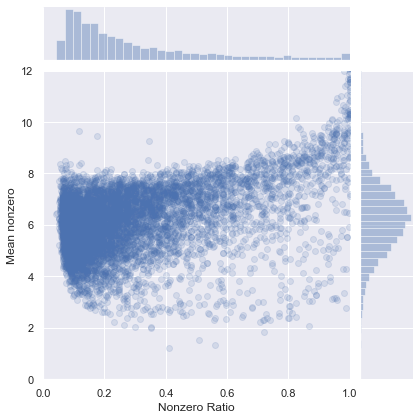

In [52]:
dm_df = dropmean(EM, 0) # Begin with cutoff at zero.
sns.set(style="darkgrid")
fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'],
               alpha=.15, xlim=(0,1), ylim=(0,12), height=6)

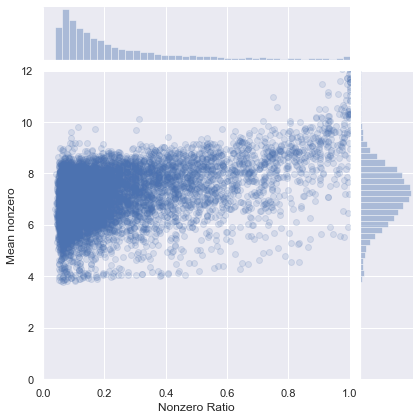

In [53]:
dm_df = dropmean(EM, 10) # Now impose a cutoff of 10.
sns.set(style="darkgrid")
fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'],
               alpha=.15, xlim=(0,1), ylim=(0,12), height=6)

The 10-count cutoff effectively removed many suspicious genes on the bottom-right.  But still, the genes around the bottom right are a bit suspicious, and could be due to bad libraries.  The following labels genes as "suspect" if they lie in a rectangle with high nonzero-ratio and low mean-nonzero value.

In [54]:
def is_suspect(df, nzr_min = 0.95, mn_max = 250):
    '''
    Identifies genes as suspect if their nonzero ratio is above nzr_min
    and their mean nonzero expression is below mn_max.
    The default mn_max is a TPM count of 250.
    '''
    mn_max_trans = log2p(mn_max)
    x = df['Nonzero Ratio']
    y = df['Mean nonzero']
    return ((x > nzr_min) & (y < mn_max_trans))

In [55]:
suspect_mask = is_suspect(dm_df, 0.95, 250)
genes_suspect = list(suspect_mask[suspect_mask].index)
print('The following genes are suspected bad libraries: \n {}.'.format(', '.join(genes_suspect)))

The following genes are suspected bad libraries: 
 ENSG00000233328, ENSG00000149480, ENSG00000165527, ENSG00000179218, ENSG00000104824, ENSG00000226608, ENSG00000159140, ENSG00000168036, ENSG00000164548, ENSG00000203396, ENSG00000223551, ENSG00000210140.


We highlight the suspect genes in red.

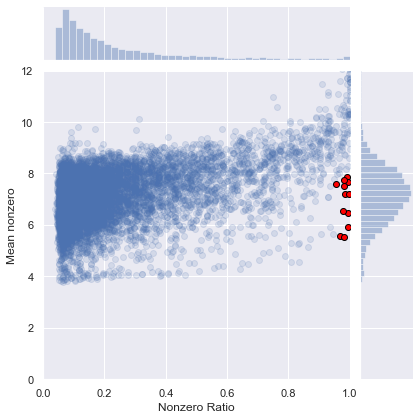

In [56]:
dm_df = dropmean(EM, 10) # Now impose a cutoff of 10.
sns.set(style="darkgrid")
fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'],
               alpha=.15, xlim=(0,1), ylim=(0,12), height=6)

dm_suspect = dm_df[suspect_mask]
plt.sca(fig.ax_joint)
plt.scatter(dm_suspect['Nonzero Ratio'], dm_suspect['Mean nonzero'], c='red', edgecolor='black', linewidth=1)
plt.savefig("test.svg")
plt.show()

Now we drop the suspicious genes, and save our munged data.

In [57]:
EM = EM.drop(genes_suspect, axis=1) # Drop the suspect genes.
EM.to_pickle('P1902_EM.pkl') # Save file as a pickle.  This will be used for downstream analysis.
print('Expression matrix pickled, with shape {}'.format(EM.shape)) 

Expression matrix pickled, with shape (345, 7432)


In [58]:
EM_bulks.to_pickle('P1902_EM_bulks.pkl') # Save file as a pickle.  This will be used for downstream analysis.
print('Expression matrix for bulks pickled, with shape {}'.format(EM_bulks.shape)) 

Expression matrix for bulks pickled, with shape (9, 9087)


## 3.  Quick shot at machine learning

After preprocessing the data, one might want to quickly check how well gene expression can predict clonotype.  The following steps will test out a linear support vector classifier. 

In [59]:
import statsmodels.api as sm

# Import various functions for stats.
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew # For detecting bimodality
from statsmodels.formula.api import ols

from bisect import bisect # See bisect.bisect.
from itertools import compress # I don't recall why this is here.

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn.preprocessing import Binarizer, MinMaxScaler

from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV

from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.metrics import accuracy_score

from sklearn.svm import LinearSVC # Linear Support Vector Classifier 
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE


In [60]:
X = EM # Features are gene expressions.
X_cells = X.index
y = meta_df.loc[X_cells].Clone_ID # Can we predict clonality of cells?

Initialize a support vector machine classifier.  The pipeline begins with a min-max scaler (scaling all gene expressions to be between 0 and 1) and then selects the top $k$ genes based on ANOVA F statistics, and then applies a linear support vector classifier.

In [61]:
SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=100), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000))

The cross-validation will take a minute.  

In [62]:
# DANGER DANGER:  The following suppresses all warnings from Python.
# Otherwise, you'll probably get a bunch of convergence warnings...
# Alternatively, increase the number of iterations in the SVM.

import warnings
warnings.filterwarnings('ignore') # Ignore warnings.

param_grid = dict(linearsvc__C=[0.001, 0.01, 0.1, 1.0, 10, 100],
                  selectkbest__k = range(50,251,25),
                 )

grid_search = GridSearchCV(SVMpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('minmaxscaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('selectkbest',
                                        SelectKBest(k=100,
                                                    score_func=<function f_classif at 0x7fc73cd089e0>)),
                                       ('linearsvc',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=2000,
                                                  multi_class='ovr',


The following function visualizes the result of cross-validation.

In [63]:
def CV_map(gs, swap=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with {0:}-fold cross-validation. \n"
                 "Best score {1:2.1%} with parameters \n"
                 "{2} ".format(gs.cv, gs.best_score_, gs.best_params_))

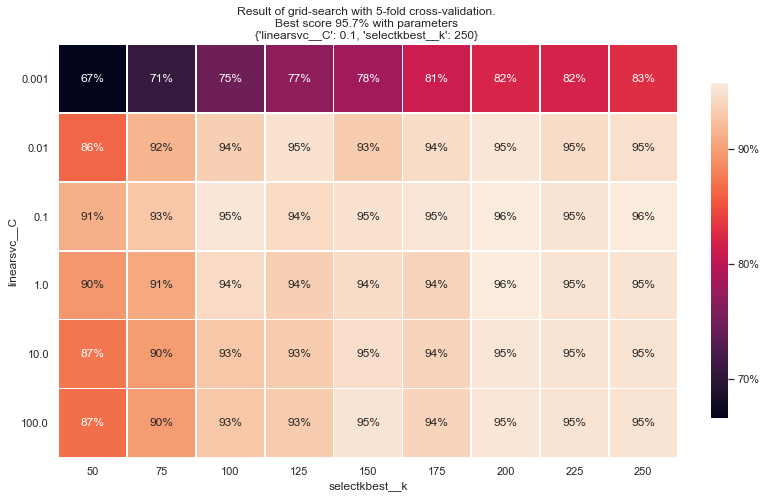

In [64]:
CV_map(grid_search)

The following plots a "confusion matrix" to see how cells belonging to one clone are classified correctly or incorrectly to another clone.

In [65]:
from sklearn import base

def confusion_matrix(X,y,pipe, reps=2, classlist = None):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    
    f, ax = plt.subplots(figsize=(len(classes)+1,len(classes)))
    sns.heatmap(valid, annot=valid, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.046, 'pad':0.04}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .5, .75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_ylabel("Actual class")
    ax.set_xlabel("Predicted class")
    ax.set_title("Overall prediction accuracy {:0.3%}. \n"
                 "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

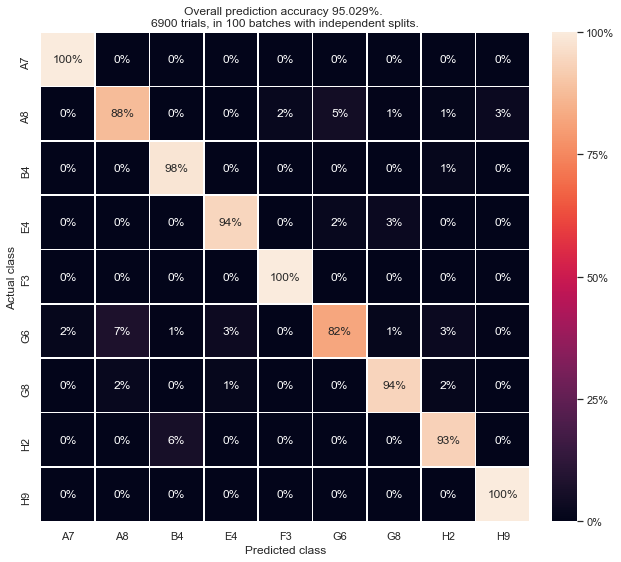

In [66]:
opt_k = grid_search.best_params_['selectkbest__k'] # Use optimal number of genes.
opt_C = grid_search.best_params_['linearsvc__C'] # Use optimal C-parameter for linear SVM.

SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=opt_k), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=opt_C))

confusion_matrix(X,y,SVMpipe, reps=100, classlist = clones)